In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [ ]:
# load the data
train_data = pd.read_csv('train_data.csv', header=None)
train_targets = pd.read_csv('train_target.csv', header=None)
test_data = pd.read_csv('test_data.csv', header=None)

# convert data to numpy arrays and reshape
X = train_data.values.astype('float32')
y = train_targets.values.squeeze().astype('int64')
X_test = test_data.values.astype('float32')

# normalize pixel values to [0, 1] and reshape to (N, 48, 48, 1)
X = X / 255.0
X = X.reshape(-1, 48, 48, 1)
X_test = X_test / 255.0
X_test = X_test.reshape(-1, 48, 48, 1)

In [ ]:
# split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# transformations for the training set
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# transformations for the validation set
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [31]:
class FacialExpressionDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images  # shape: (N, 48, 48, 1)
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # shape: (48, 48, 1)
        image = image.squeeze()   # shape: (48, 48)

        # convert to PIL Image for transformations
        image = transforms.ToPILImage()(image)

        if self.transform:
            image = self.transform(image)

        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image

In [ ]:
# create datasets
train_dataset = FacialExpressionDataset(X_train, y_train, transform=transform_train)
val_dataset = FacialExpressionDataset(X_val, y_val, transform=transform_val)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
class FacialExpressionCNN(nn.Module):
    def __init__(self):
        super(FacialExpressionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # output: 32x48x48
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),                          # output: 32x24x24

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # output: 64x24x24
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),                          # output: 64x12x12

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# output: 128x12x12
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),                          # output: 128x6x6
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 3)  # output layer for 3 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 128 * 6 * 6) # flattens
        x = self.fc_layers(x)
        return x

In [ ]:
model = FacialExpressionCNN()

# check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training Loop
best_val_accuracy = 0.0
num_epochs = 20

for epoch in range(num_epochs):
    # **Training Phase** #
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device) 
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    epoch_loss = train_loss / len(train_dataset)

    # **Validation Phase** #
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)  # get predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_dataset)    
    val_accuracy = correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Acc: {val_accuracy:.4f}')    
        
    # save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print('Model saved!')

Epoch [1/20], Train Loss: 1.0169, Val Loss: 0.8143, Val Acc: 0.6357
Model saved!
Epoch [2/20], Train Loss: 0.8081, Val Loss: 0.6818, Val Acc: 0.7008
Model saved!
Epoch [3/20], Train Loss: 0.7150, Val Loss: 0.6412, Val Acc: 0.7237
Model saved!
Epoch [4/20], Train Loss: 0.6641, Val Loss: 0.6075, Val Acc: 0.7365
Model saved!
Epoch [5/20], Train Loss: 0.6248, Val Loss: 0.5874, Val Acc: 0.7480
Model saved!
Epoch [6/20], Train Loss: 0.5958, Val Loss: 0.5709, Val Acc: 0.7694
Model saved!
Epoch [7/20], Train Loss: 0.5794, Val Loss: 0.5605, Val Acc: 0.7655
Epoch [8/20], Train Loss: 0.5588, Val Loss: 0.5688, Val Acc: 0.7715
Model saved!
Epoch [9/20], Train Loss: 0.5375, Val Loss: 0.5531, Val Acc: 0.7678
Epoch [10/20], Train Loss: 0.5253, Val Loss: 0.5586, Val Acc: 0.7814
Model saved!
Epoch [11/20], Train Loss: 0.5128, Val Loss: 0.5386, Val Acc: 0.7762
Epoch [12/20], Train Loss: 0.4946, Val Loss: 0.5352, Val Acc: 0.7826
Model saved!
Epoch [13/20], Train Loss: 0.4794, Val Loss: 0.5429, Val Acc: 0.

In [36]:
# load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

# Test Data and Submission Prep
test_dataset = FacialExpressionDataset(X_test, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
all_predictions = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())

submission_df = pd.DataFrame({
    'Id': np.arange(len(all_predictions)),
    'Category': all_predictions
})

submission_df.to_csv('submission.csv', index=False)

C:\Users\Elite\AppData\Local\Temp\ipykernel_35112\1168374909.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [ ]:
def view_classify(img, model, class_names):
    """
    Parth Dhameliya
    Machine Learning Instructor Coursera
    https://www.coursera.org/projects/facial-expression-recognition-with-pytorch 
    (demonstrated the function for image classification probability outputs)

    Displays an image and the model's predicted probabilities for each class.
    """
    # prep the image
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = nn.functional.softmax(output[0], dim=0).cpu().numpy()

    # plot image
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # plot probabilities
    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(class_names))
    plt.barh(y_pos, probabilities, align='center')
    plt.yticks(y_pos, class_names)
    plt.xlabel('Probability')
    plt.xlim([0, 1])
    plt.tight_layout()
    plt.show()

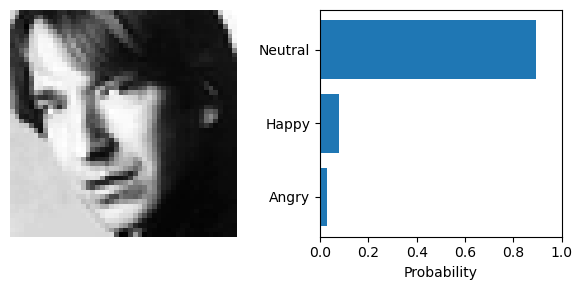

In [ ]:
from PIL import Image

class_names = ['Angry', 'Happy', 'Neutral']

# indices used for poster: 4, 125, 800, 1050

# load an image from the validation set
sample_idx = 1050 # Change this index to view different images
sample_image, sample_label = val_dataset[sample_idx]

# convert tensor image back to PIL Image for display
inv_normalize = transforms.Normalize(
    mean=[-0.5 / 0.5],
    std=[1 / 0.5]
)
img = inv_normalize(sample_image).squeeze().cpu().numpy()
img = (img * 255).astype(np.uint8)
img = Image.fromarray(img)

view_classify(img, model, class_names)